In [1]:
%pip install numba
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


The TRUE wave equation (with damping and stress-strain coupling):

$$\frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2}\frac{\partial^2 y}{\partial t^2} - \gamma \frac{\partial y}{\partial t} -l^2 \frac{\partial^4 y}{\partial x^4} = 0 $$

$$ y(0, t) = y(L, t) = 0 $$
$$ y(x, 0) = f(x) $$

$y$ is the amplitude of the string, $x$ is the location of the string, and $t$ is time.

Parameters:

* $c$: speed of the wave $[m/s]$
* $\gamma$: damping constant $[s/m]$
* $l$: characteristic length (stiffness term) [dimensionless]

Discrete form:

$$\frac{y_{j+1}^{m} -2y_j^m + y_{j-1}^{m}}{\Delta x^2} - \frac{1}{c^2}\frac{y_j^{m+1} -2y_j^m + y_j^{m-1}}{\Delta t^2} - \gamma \frac{y_j^{m+1} - y_j^{m-1}}{2 \Delta t} - l^2 \frac{y_{j-2}^m -4y_{j-1}^m +4y_{j}^m -4y_{j+1}^m +y_{j+2}^m}{\Delta x^4} =0 $$ 

Solve for $y_j^{m+1}$ (the amplitude of the string at the next time):

$$y_j^{m+1} = \left[\frac{1}{c^2 \Delta t^2} + \frac{\gamma}{2 \Delta t} \right]^{-1} \left[\frac{1}{\Delta x^2} \left( y_{j+1}^{m} -2y_j^m + y_{j-1}^{m} \right) -\frac{1}{c^2 \Delta t^2} \left( y_j^{m-1} - 2y_j^m \right) + \frac{\gamma}{2 \Delta t}y_j^{m-1} -\frac{l^2}{\Delta x^4} \left( y_{j-2}^m -4y_{j-1}^m +6y_{j}^m -4y_{j+1}^m +y_{j+2}^m \right) \right] $$

In order for this to be stable, need $c \Delta t/\Delta x < 1$

# Solving

Guitar string length  $\boxed{L = 0.7~\text{m}}$

Choose $\boxed{N_x=101}$ guitar string positions $\implies$ $\boxed{\Delta x = 0.7~\text{mm}}$

Note that the fundamental frequency of a guitar note is $f = c/2L$. With an "A note" at 220Hz get $\boxed{c = 308~\text{m/s}} $

To obey our constraint we thus set $\boxed{\Delta t = 5 \times 10^{-6} s}$. In order to get multiple seconds of a result, choose $\boxed{N_t = 500000}$

Two parameters that seemed to give a solution that sounded like a string were $\boxed{l= 2 \times 10^{-6}}$ and $\boxed{\gamma = 2.6 \times 10^{-5} s/m}$



In [2]:
Nx = 101
Nt = 500000
L =0.7
dx = L/(Nx-1)
f = 440
c = 2*L*f
dt = 5e-6
l=5e-5
gamma=5e-5

Initial state of the string:

In [3]:
ya = np.linspace(0, 0.01, 70)
yb = np.linspace(0.01, 0, 31)
y0 = np.concatenate([ya, yb])

Create 2D array of $y(x, t)$

In [4]:
sol = np.zeros((Nt, Nx))

Make the solution at $t=0$ and $t=1$ equal to the "pluck"

In [5]:
sol[0] = y0
sol[1] = y0

Go through the iterative procedure:

In [6]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8)", nopython=True, nogil=True)
def compute_d(d, times, length, dt, dx, l, gamma):
    for t in range(1, times-1):
        for i in range(2, length-2):
            outer_fact = (1/(c**2 * dt**2) + gamma/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4)
    return d

In [7]:
sol = compute_d(sol, Nt, Nx, dt, dx, l, gamma)

Plot the string at some sample points

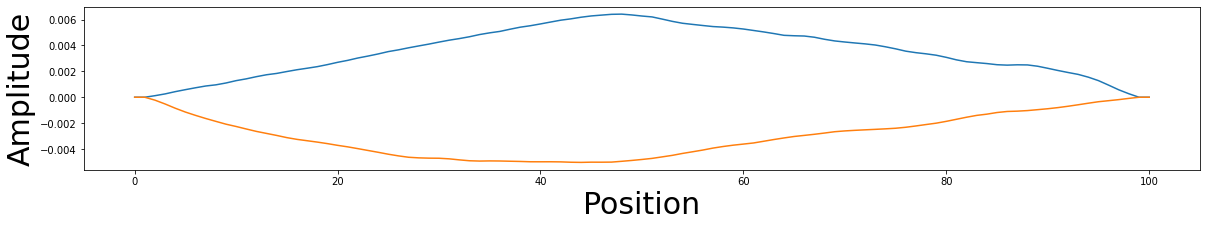

In [8]:
plt.figure(figsize=(20,3))
plt.plot(sol[500])
plt.plot(sol[10000])
plt.xlabel('Position', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.savefig('sample.png')

Make an animation of the string: (1/dt is fps)

In [9]:
len(sol[::10,:])

50000

So 200000 fps. Lets only index every 10 frames which gives 20000 fps. If we choose a gif fps of 20, this means our animation is moving 1000x slower than real life

In [10]:
# def animate(i):
#     ax.clear()
#     ax.plot(sol[i*10])
#     ax.set_ylim(-0.01, 0.01)
    
# fig, ax = plt.subplots(1,1)
# ax.set_ylim(-0.01, 0.01)
# ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
# ani.save('string.gif',writer='pillow',fps=20)

# Create .WAV file of noise

Extract the "amount" of the harmonics at any time $t$:

$$ \text{Amplitude of harmonic n at time t} \propto \int_{0}^L y(x, t) \sin(n \pi x / L) dx $$

In [11]:
# This is the way I did it in the video
# def get_integral(n):
#     sin_arr = np.sin(n*np.pi*np.linspace(0,1,101))
#     return np.array([sum(sin_arr*s) for s in sol])

# This is the same as the function above. but runs WAAYYY faster. Use this instead; it is far more optimized
def get_integral_fast(n):
    sin_arr = np.sin(n*np.pi*np.linspace(0,1,101))
    return np.multiply(sol, sin_arr).sum(axis=1)

In [12]:
hms = [get_integral_fast(n) for n in range(10)]

Add them together

In [13]:
all_harmonics=True
if all_harmonics:
    tot = sol.sum(axis=1)[::10] # all harmonics
else:
    tot = sum(hms)[::10] # only first 10 harmonics
tot = tot.astype(np.float32)

Make a WAV file

In [14]:
from scipy.io import wavfile
from IPython.display import Audio

In [15]:
wavfile.write('A.wav',20000,tot)
Audio('A.wav')

In [16]:
from scipy.io.wavfile import read
a = read('sounds/A.wav')[1]
b = read('sounds/B.wav')[1]
cs = read('sounds/C#.wav')[1]
d = read('sounds/D.wav')[1]
e = read('sounds/E.wav')[1]
fs = read('sounds/F#.wav')[1]

a = np.append(a, np.zeros(100))
b = np.append(np.zeros(100), b)
b = np.append(b, np.zeros(0))
# , np.zeros(14000-1000)
d = np.append(np.zeros(100), d)
fs = np.concatenate([np.zeros(14000-1000), fs, np.zeros(1000)])
tot = a + b + d
# + c + d + 0.4*f
tot = tot.astype(np.float32)


In [17]:
wavfile.write('music.wav',20000,tot)
Audio('music.wav')

# Generated Songs

In [18]:
%pip install pygame
from threading import Thread
import pygame as pg 
import time 

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
pygame 2.1.2 (SDL 2.0.18, Python 3.10.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [19]:

Twinkle_List = ["E","E","E","E","E","E","E","G","C","D","E",\
	"F","F","F","F","F","E","E","E","E","D","D","E","D","G"]
# ["A","B","D","B","F#","F#","F#","E",\
# "A","B","D","B","E","E","E","D","C#","B"] Never Gonna Give You Up Notes

pg.mixer.init()
pg.init()

pg.mixer.set_num_channels(len(Twinkle_List))

def play_notes(notePath,duration):
	time.sleep(duration) # make a pause 
	pg.mixer.Sound(notePath).play()
	time.sleep(duration) # Let the sound play 
	print(notePath) # To see which note is now playing

path  = 'Sounds/'

cnt =1	# A counter to delay once a line is finished as there
# are 6 total lines
cnt2=0
cnt3=1

th = {}
for t in Twinkle_List:
	file = path+'{}.wav'.format(t)
	# These are arguments (path+'{}.wav'.format(t),0.3)
	# Lets start the thread

	play_notes(file,0.25)

	if (cnt3==11):
		print("---Long Pause---")
		time.sleep(1.5)

	if (cnt3==24):
		print("---Long Pause---")
		time.sleep(0.75)

	if cnt2<2:
		if cnt%3==0:
			print("---Short Pause---")
			time.sleep(0.5) # Let the sound play for the last note of each line
			cnt2+=1
		cnt+=1
	cnt3+=1

print('Have a very merry Christmas!')

	


Sounds/E.wav
Sounds/E.wav
Sounds/E.wav
---Short Pause---
Sounds/E.wav
Sounds/E.wav
Sounds/E.wav
---Short Pause---
Sounds/E.wav
Sounds/G.wav
Sounds/C.wav
Sounds/D.wav
Sounds/E.wav
---Long Pause---
Sounds/F.wav
Sounds/F.wav
Sounds/F.wav
Sounds/F.wav
Sounds/F.wav
Sounds/E.wav
Sounds/E.wav
Sounds/E.wav
Sounds/E.wav
Sounds/D.wav
Sounds/D.wav
Sounds/E.wav
Sounds/D.wav
---Long Pause---
Sounds/G.wav
Have a very merry Christmas!
